#**Предобработка данных**



In [16]:
#импортирование данных
import pandas as pd

file_path = '/content/dataset_hac.xlsx'
employee_comments = pd.read_excel(file_path, sheet_name='Workers')
hr_comments = pd.read_excel(file_path, sheet_name='HR')
data = pd.DataFrame(employee_comments.apply(lambda row: ' '.join([str(row[col]) for col in ['В1', 'В1.1'] if pd.notna(row[col])]), axis=1))


In [17]:
# Удаление или замена пропущенных значений
data.dropna(inplace=True)

# Удаление дублирующих записей
data.drop_duplicates(inplace=True)

In [3]:
!pip install pymorphy2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 68.4 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=b8a6f00926c5308b6aaf91b50e7baab153d4f51fb398bc5f61dd78c8556c433f
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [18]:
import pymorphy2

# Инициализация морфологического анализатора
morph = pymorphy2.MorphAnalyzer()

def lemmatize_word(word):

    parsed_word = morph.parse(word)[0]
    return parsed_word.normal_form

def lemmatize_text(text):

    # Разбиваем текст на слова, лемматизируем каждое слово и собираем обратно в строку
    lemmatized_words = [lemmatize_word(word) for word in text.split()]
    return ' '.join(lemmatized_words)


In [19]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Загрузка необходимых ресурсов NLTK
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Нормализация текста
def preprocess_text(text):
    text = text.lower()  # Приведение к нижнему регистру
    text = re.sub(r'\W', ' ', text)  # Удаление знаков препинания
    tokens = text.split()  # Токенизация
    tokens = [word for word in tokens if word not in stopwords.words('russian')]  # Удаление стоп-слов
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Лемматизация
    return ' '.join(tokens)

data[0] = data[0].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Эксперементируем с разными вариациями моделей\
В конце будет итоговая модель\
Решаемая задача: **Кластеризация**


# Обучени




1. Делаем бэйзлайн

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Преобразование текста в TF-IDF векторы
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data[0])

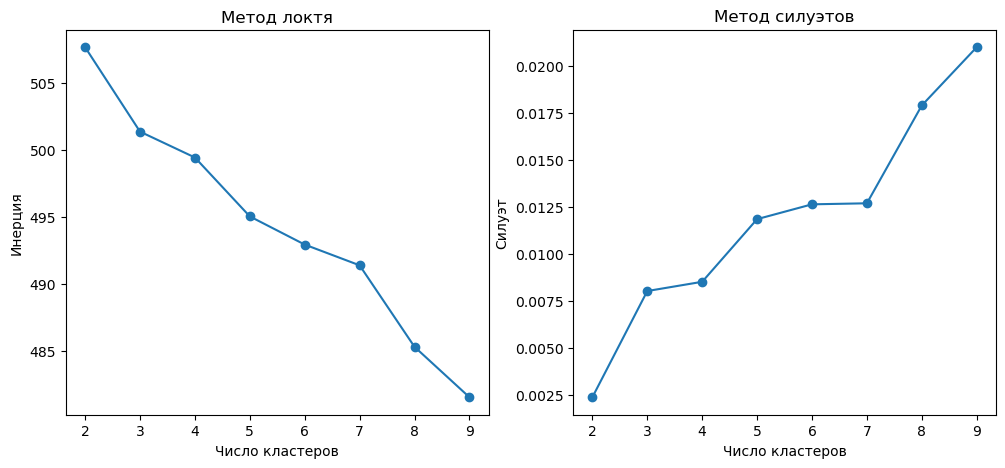

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Метод локтя
inertia = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# График метода локтя
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.title('Метод локтя')
plt.xlabel('Число кластеров')
plt.ylabel('Инерция')

# График метода силуэтов
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='o')
plt.title('Метод силуэтов')
plt.xlabel('Число кластеров')
plt.ylabel('Силуэт')
plt.show()


In [ ]:
# Применение K-Means для кластеризации
optimal_k = 7
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['cluster'] = kmeans.fit_predict(X)

# Оценка результатов кластеризации
print(silhouette_score(X, data['cluster']))


0.012679617332130829


In [ ]:
def get_top_keywords(cluster, n=10):
    cluster_data = data[data['cluster'] == cluster]
    tfidf_matrix = vectorizer.transform(cluster_data[0])
    feature_array = vectorizer.get_feature_names_out()
    tfidf_sorting = tfidf_matrix.sum(axis=0).A1.argsort()[::-1]
    top_keywords = feature_array[tfidf_sorting][:n]
    return top_keywords

for i in range(optimal_k):
    print(f"Кластер {i}: {get_top_keywords(i)}")


Кластер 0: ['уровень' 'деятельности' 'перевод' 'частые' 'зп' 'заработной' 'платы'
 'месте' 'предложили' 'командировки']
Кластер 1: ['отсутствие' 'работу' 'работы' 'сотрудников' 'работать' 'возможность'
 'компании' 'который' 'задач' 'нашла']
Кластер 2: ['переезд' 'обстоятельствам' 'семейным' 'город' 'вынужденный' 'регион'
 'страну' 'другую' 'жительства' 'аккую']
Кластер 3: ['здоровья' 'состоянию' 'ухожу' 'заслуженный' 'отдых' 'состояние' 'случае'
 'моего' 'моем' 'перенесенной']
Кластер 4: ['пенсию' 'выход' 'связи' 'уходом' 'выходом' 'причине' 'ухода' 'уход'
 'выхожу' 'увольняюсь']
Кластер 5: ['работы' 'обстоятельства' 'работа' 'выгорание' 'семейные' 'руководства'
 'эмоциональное' 'несогласие' 'которые' 'стилем']
Кластер 6: ['компании' 'компания' 'коллектив' 'руководство' 'очень' 'отрасли'
 'гринатом' 'переход' 'которую' 'хорошая']


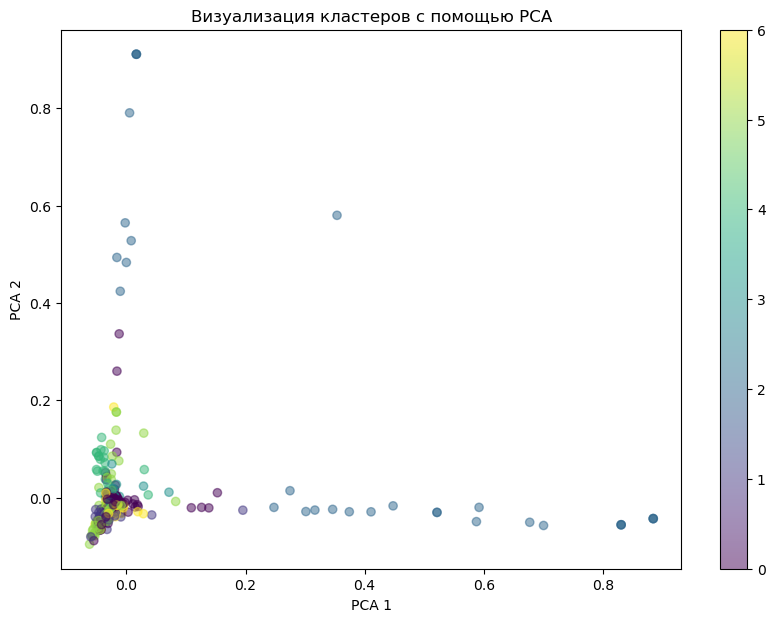

In [ ]:
from sklearn.decomposition import PCA

# Уменьшение размерности с помощью PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 7))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data['cluster'], cmap='viridis', alpha=0.5)
plt.title('Визуализация кластеров с помощью PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()


2. Пробуем обработать слова по-другому

C:\Users\dimak\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


C:\Users\dimak\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dimak\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Качество кластеризации (Силуэт): 0.13797224


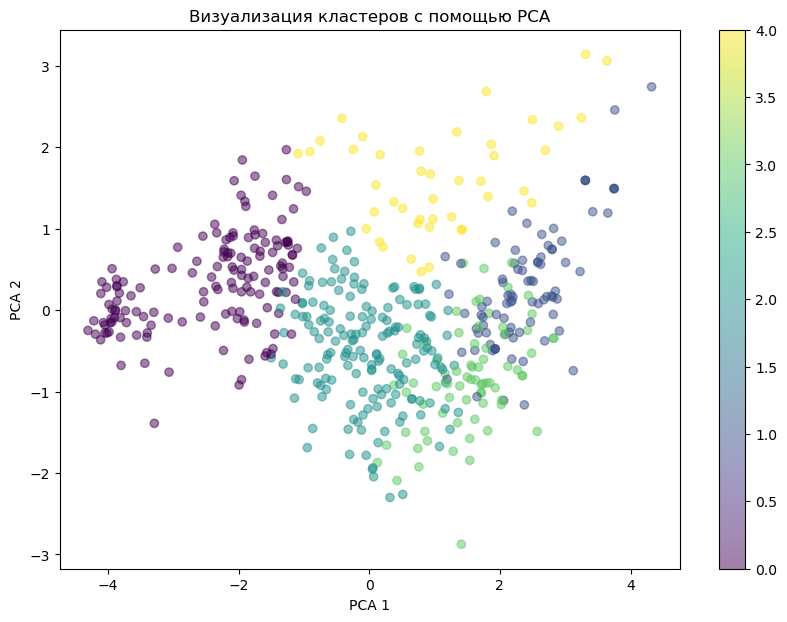

Кластер 0: 1 включение нового кпэ продажам который имеет отношения моему основному функционалу 2 блокирование приёма персонала текущую реализацию проектов сохранения компетенций
Кластер 1: переезд
Кластер 2: 1 переезд город 2 нездоровая атмосфера прихода нового директора персоналу её команды ключевые позиции 3 невозможность текущими условиями обеспечить второе высшее обучение профессиональные сертификаты
Кластер 3: выход пенсию
Кластер 4: бюрократия повышение сотрудников выслугу лет компетенции ипр ведется галочки реальности никто заинтересован твоем развитии отсутствие проф обучений


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import re

# Использование BERT для преобразования текста в векторы
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def embed_text(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# Преобразование всех текстов в векторы
embeddings = np.array([embed_text(text) for text in data[0]])

# Кластеризация с использованием KMeans
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['cluster'] = kmeans.fit_predict(embeddings)

# Оценка результатов кластеризации
silhouette_avg = silhouette_score(embeddings, data['cluster'])
print("Качество кластеризации (Силуэт):", silhouette_avg)

# Визуализация результатов с использованием PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data['cluster'], cmap='viridis', alpha=0.5)
plt.title('Визуализация кластеров с помощью PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()

# Обобщение ключевых слов до одного ключевого слова для каждого кластера
def get_representative_keyword(cluster):
    cluster_data = data[data['cluster'] == cluster]
    most_frequent_text = cluster_data[0].mode()[0]
    return most_frequent_text

for i in range(optimal_k):
    representative_keyword = get_representative_keyword(i)
    print(f"Кластер {i}: {representative_keyword}")


3. Пробуем использовать другие модели для кластерищации

Качество кластеризации (kmeans): 0.13797224
Качество кластеризации (dbscan): None
Качество кластеризации (agglo): 0.11374364
Качество кластеризации (gmm): 0.13797224


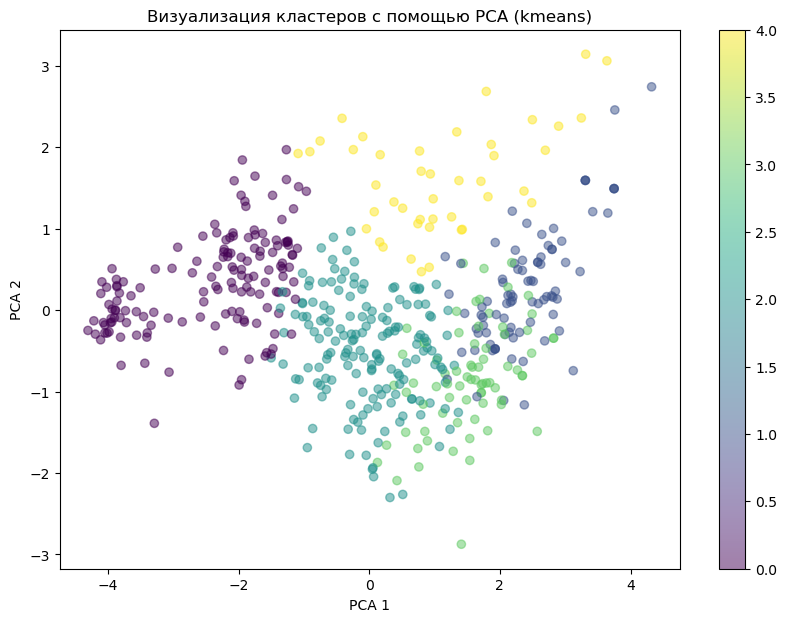

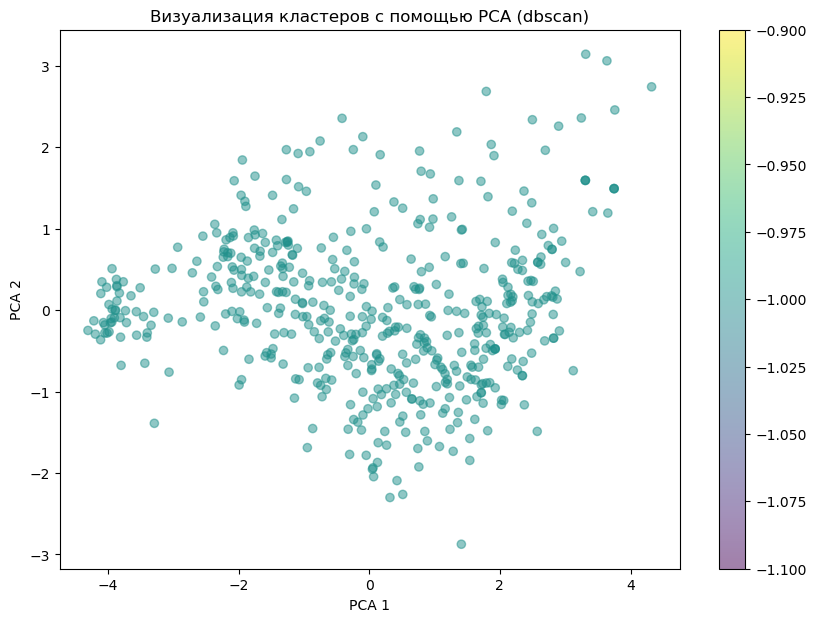

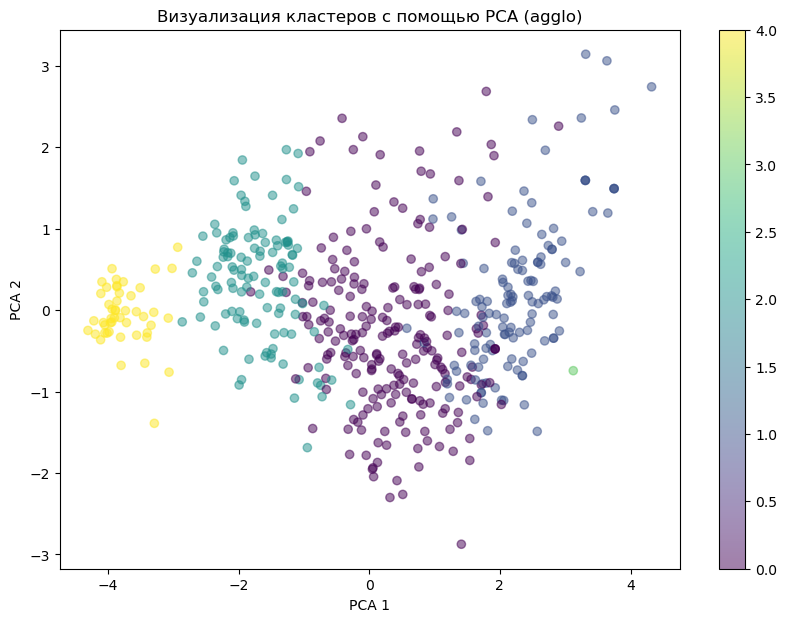

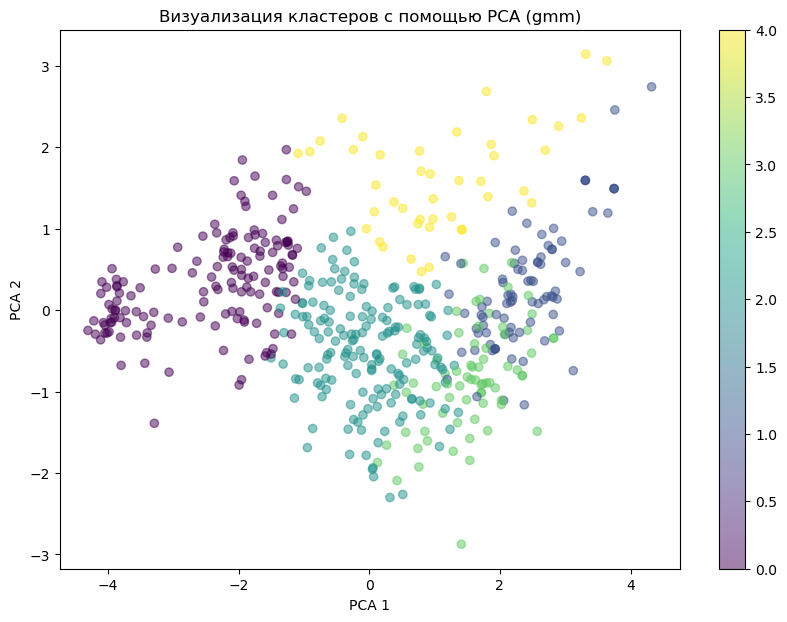

Кластер 0: очень понравилась компания жалко покидать нашей группе обучения экзамены целом обстановка располагает развитию знаний навыков сотрудников нововведения воспринимаются штыки считается работать очень глубокой старинке непосредственный руководитель доводит рабочую информацию исполнителей помогает решать возникающие ходе работы вопросы
Кластер 1: работа срочным договорам перевода бессрочный
Кластер 2: накопленные годами проблемы должны решаться одним человеком кратчайшие сроки
Кластер 3: связи уходом пенсию старости спасибо работу
Кластер 4: очередная трансформация службы переводом сотрудников одной компании другую


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import re
from sklearn.feature_extraction.text import TfidfVectorizer


# Использование BERT для преобразования текста в векторы
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def embed_text(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# Преобразование всех текстов в векторы
embeddings = np.array([embed_text(text) for text in data[0]])

# Кластеризация с использованием разных моделей
# 1. KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
data['cluster_kmeans'] = kmeans.fit_predict(embeddings)

# 2. DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
data['cluster_dbscan'] = dbscan.fit_predict(embeddings)

# 3. Agglomerative Clustering
agg_clust = AgglomerativeClustering(n_clusters=5)
data['cluster_agglo'] = agg_clust.fit_predict(embeddings)

# 4. Gaussian Mixture Models
gmm = GaussianMixture(n_components=5, random_state=42)
data['cluster_gmm'] = gmm.fit_predict(embeddings)

# Оценка результатов кластеризации
for method in ['kmeans', 'dbscan', 'agglo', 'gmm']:
    if method == 'dbscan':
        silhouette_avg = None  # DBSCAN может давать -1 для выбросов
    else:
        silhouette_avg = silhouette_score(embeddings, data[f'cluster_{method}'])
    print(f"Качество кластеризации ({method}):", silhouette_avg)

# Визуализация результатов с использованием PCA
for method in ['kmeans', 'dbscan', 'agglo', 'gmm']:
    plt.figure(figsize=(10, 7))
    reduced_data = PCA(n_components=2).fit_transform(embeddings)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data[f'cluster_{method}'], cmap='viridis', alpha=0.5)
    plt.title(f'Визуализация кластеров с помощью PCA ({method})')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.colorbar()
    plt.show()

# Выбор ключевого слова на основе суммирования векторов
def get_representative_keyword(cluster_label):
    cluster_data = data[data['cluster_kmeans'] == cluster_label]
    if cluster_data.empty:
        return "Нет данных"

    # Получение векторов для каждого текста в кластере
    cluster_embeddings = np.array([embed_text(text) for text in cluster_data[0]])

    # Суммирование векторов и получение "центроида" кластера
    centroid = np.mean(cluster_embeddings, axis=0)

    # Поиск ближайшего текста к центроиду
    distances = np.linalg.norm(cluster_embeddings - centroid, axis=1)
    nearest_index = np.argmin(distances)

    return cluster_data[0].iloc[nearest_index]

# Обобщение ключевых слов для каждого кластера
for i in range(5):  # Замените на ваше количество кластеров
    representative_keyword = get_representative_keyword(i)
    print(f"Кластер {i}: {representative_keyword}")


4. Пробуем использовать языковые модели для суммаризации а также для выделения ключевого слова кластера

Качество кластеризации (Силуэт): 0.5053352


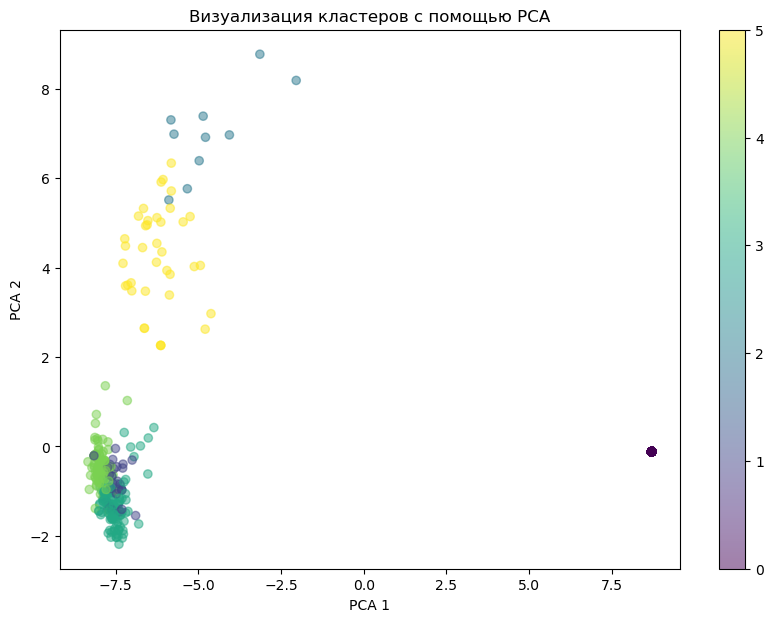

Ошибка: index (526) out of range
Кластер 0:
- Ключевое слово: Error in calculating top keyword
- Краткое описание: 


Кластер 1:
- Ключевое слово: комании
- Краткое описание: ib


Кластер 2:
- Ключевое слово: company
- Краткое описание: reducing the cost


Ошибка: index (525) out of range
Кластер 3:
- Ключевое слово: Error in calculating top keyword
- Краткое описание: у ен


Ошибка: index (527) out of range
Кластер 4:
- Ключевое слово: Error in calculating top keyword
- Краткое описание: if a


Кластер 5:
- Ключевое слово: proposal
- Краткое описание: 0




In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration


tokenizer_t5 = T5Tokenizer.from_pretrained('google/flan-t5-small')
model_t5 = T5ForConditionalGeneration.from_pretrained('google/flan-t5-small')

# Функция для сжатия текста на 70%
def summarize_text(text, compression_ratio=0.75):
    if not text or len(text.strip()) == 0:
        return ""

    inputs = tokenizer_t5.encode(text, return_tensors='pt', max_length=512, truncation=True)
    original_length = len(inputs[0])

    # Проверяем, что длина не становится слишком короткой
    new_max_length = max(10, int(original_length * (1 - compression_ratio)))

    # Генерация сжатого текста с DistilT5
    try:
        summary_ids = model_t5.generate(inputs, max_length=new_max_length, num_beams=2, early_stopping=True)
        summary = tokenizer_t5.decode(summary_ids[0], skip_special_tokens=True)
    except Exception as e:
        print(f"Ошибка при генерации текста: {e}")
        return text  # Возвращаем оригинальный текст в случае ошибки

    return summary

# Применяем сокращение текста к каждому предложению
data['summarized_text'] = data[0].apply(lambda x: summarize_text(x, compression_ratio=0.75))

# Преобразование текстов в векторы с использованием BERT
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')

def embed_text(text):
    inputs = tokenizer_bert(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model_bert(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# Преобразование всех сокращенных текстов в векторы
embeddings = np.array([embed_text(text) for text in data['summarized_text']])

# Кластеризация с использованием KMeans
optimal_k = 6  # Определить оптимальное количество кластеров
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['cluster'] = kmeans.fit_predict(embeddings)

# Оценка результатов кластеризации
silhouette_avg = silhouette_score(embeddings, data['cluster'])
print("Качество кластеризации (Силуэт):", silhouette_avg)

# Визуализация результатов с использованием PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data['cluster'], cmap='viridis', alpha=0.5)
plt.title('Визуализация кластеров с помощью PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()

# Определение ключевого слова для каждого кластера с использованием TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = vectorizer.fit_transform(data['summarized_text'])
feature_names = vectorizer.get_feature_names_out()

def get_top_keyword(cluster_label):
    # Получаем данные для кластера
    cluster_data = data[data['cluster'] == cluster_label]

    # Получаем индексы строк, которые соответствуют кластеру
    cluster_indices = cluster_data.index.tolist()

    if not cluster_indices:
        return "No data for this cluster"

    # Получаем TF-IDF для строк этого кластера
    try:
        # Считаем среднее значение по строкам
        cluster_tfidf = tfidf_matrix[cluster_indices].mean(axis=0)

        # Преобразуем в массив NumPy
        cluster_tfidf_array = np.array(cluster_tfidf).flatten()

        # Находим индекс слова с максимальным значением TF-IDF
        top_word_index = np.argmax(cluster_tfidf_array)

        # Получаем ключевое слово по индексу
        top_keyword = feature_names[top_word_index]
        return top_keyword
    except IndexError as e:
        print(f"Ошибка: {e}")
        return "Error in calculating top keyword"

# Генерация краткого описания кластера (до 5 слов) с помощью T5
def generate_short_description(cluster_label):
    cluster_data = data[data['cluster'] == cluster_label]
    all_text = " ".join(cluster_data['summarized_text'].tolist())
    inputs = tokenizer_t5.encode("summarize: " + all_text, return_tensors='pt', max_length=512, truncation=True)

    summary_ids = model_t5.generate(inputs, max_length=5, min_length=2, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer_t5.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Вывод результатов по каждому кластеру
for i in range(optimal_k):
    top_keyword = get_top_keyword(i)
    short_description = generate_short_description(i)

    print(f"Кластер {i}:")
    print(f"- Ключевое слово: {top_keyword}")
    print(f"- Краткое описание: {short_description}")
    print("\n")


5.Пытаемся ускорить работу модели так как очень долго работает

Качество кластеризации (KMeans): 0.12248153


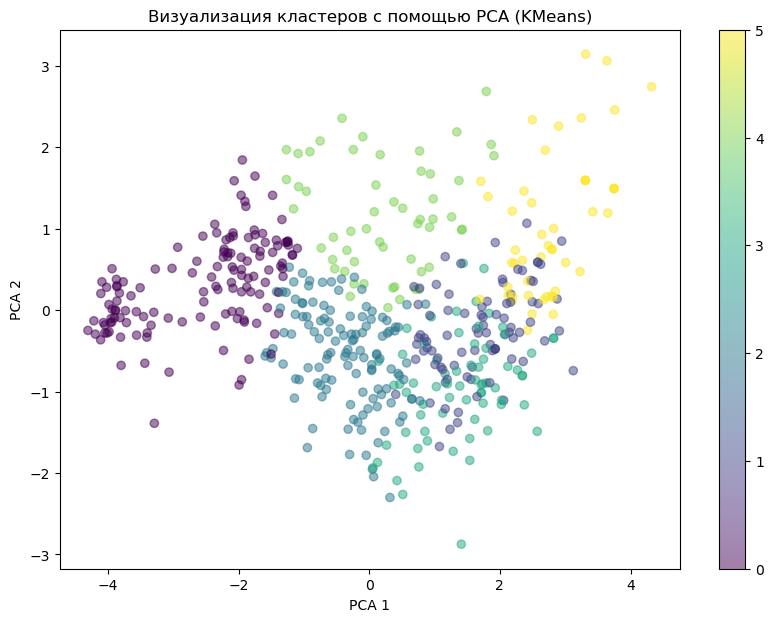

Кластер 0: работы
Кластер 1: работы
Кластер 2: работы
Кластер 3: пенсию
Кластер 4: сотрудников
Кластер 5: переезд


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.feature_extraction.text import TfidfVectorizer

# Использование BERT для преобразования текста в векторы
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def embed_text(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# Преобразование всех текстов в векторы
embeddings = np.array([embed_text(text) for text in data[0]])

# Кластеризация с использованием KMeans
kmeans = KMeans(n_clusters=6, random_state=42)
data['cluster_kmeans'] = kmeans.fit_predict(embeddings)

# Оценка качества кластеризации
silhouette_avg = silhouette_score(embeddings, data['cluster_kmeans'])
print(f"Качество кластеризации (KMeans):", silhouette_avg)

# Визуализация результатов с использованием PCA
reduced_data = PCA(n_components=2).fit_transform(embeddings)
plt.figure(figsize=(10, 7))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data['cluster_kmeans'], cmap='viridis', alpha=0.5)
plt.title('Визуализация кластеров с помощью PCA (KMeans)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()

# Выбор ключевого слова на основе TF-IDF
def get_representative_keyword(cluster_label):
    cluster_data = data[data['cluster_kmeans'] == cluster_label]
    if cluster_data.empty:
        return "Нет данных"

    # Использование TF-IDF для нахождения ключевого слова
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(cluster_data[0])
    feature_names = vectorizer.get_feature_names_out()

    # Получение среднего TF-IDF для каждого слова
    avg_tfidf = tfidf_matrix.mean(axis=0).A1  # Преобразуем в одномерный массив
    top_word_index = np.argmax(avg_tfidf)  # Индекс слова с максимальным TF-IDF
    return feature_names[top_word_index]

# Обобщение ключевых слов для каждого кластера
for i in range(6):  # Используем количество кластеров
    representative_keyword = get_representative_keyword(i)
    print(f"Кластер {i}: {representative_keyword}")


6. Пытаемся выделить слова по-другому

C:\Users\dimak\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


Качество кластеризации (KMeans): 0.12248153


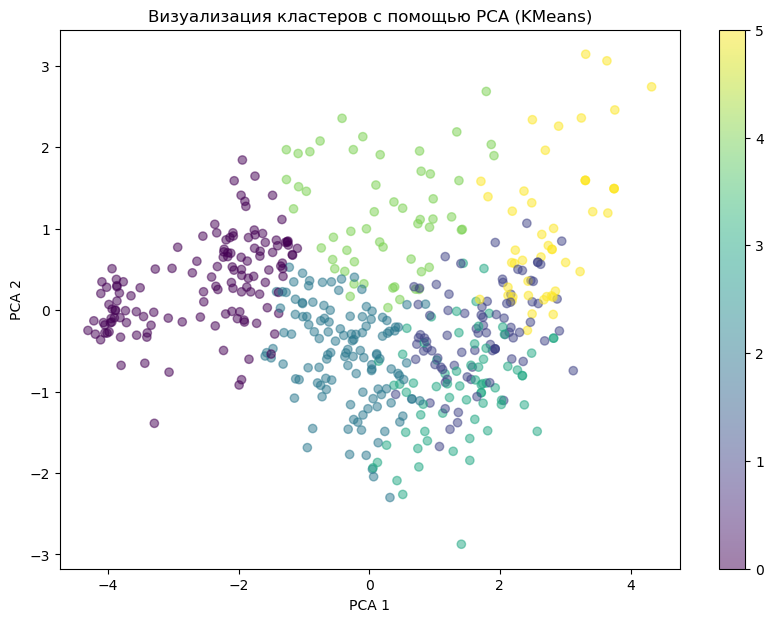

Кластер 0: работы пенсию это
Кластер 1: отсутствие работы компании
Кластер 2: работы это отрасли
Кластер 3: работы компании уровень
Кластер 4: переезд работы отсутствие
Кластер 5: обстоятельства семейные предложили


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Использование BERT для преобразования текста в векторы
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def embed_text(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# Преобразование всех текстов в векторы
embeddings = np.array([embed_text(text) for text in data[0]])

# Кластеризация с использованием KMeans
kmeans = KMeans(n_clusters=6, random_state=42)
data['cluster_kmeans'] = kmeans.fit_predict(embeddings)

# Оценка качества кластеризации
silhouette_avg = silhouette_score(embeddings, data['cluster_kmeans'])
print(f"Качество кластеризации (KMeans):", silhouette_avg)

# Визуализация результатов с использованием PCA
reduced_data = PCA(n_components=2).fit_transform(embeddings)
plt.figure(figsize=(10, 7))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data['cluster_kmeans'], cmap='viridis', alpha=0.5)
plt.title('Визуализация кластеров с помощью PCA (KMeans)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()

# Преобразование текста в формат, подходящий для LDA
vectorizer = CountVectorizer(stop_words='english')
count_data = vectorizer.fit_transform(data[0])

# Применение LDA для определения тем
lda = LatentDirichletAllocation(n_components=6, random_state=42)
lda.fit(count_data)

# Функция для извлечения ключевых слов из темы
def get_lda_keywords(lda_model, feature_names, n_top_words):
    keywords = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        keywords.append(" ".join(top_words))
    return keywords

# Получение ключевых слов для каждой темы
n_top_words = 3  # количество ключевых слов для каждой темы
feature_names = vectorizer.get_feature_names_out()
lda_keywords = get_lda_keywords(lda, feature_names, n_top_words)

# Обобщение ключевых слов для каждого кластера
for i in range(6):  # Используем количество кластеров
    representative_keywords = lda_keywords[i]
    print(f"Кластер {i}: {representative_keywords}")


# Итоговая модель



7. Итоговая модель. Она работает быстрее,а также выдает более осмысленный результат разделения на кластеры

In [7]:
!pip install keybert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 8.0 MB/s eta 0:00:00


Качество кластеризации (KMeans): 0.02085864694143628


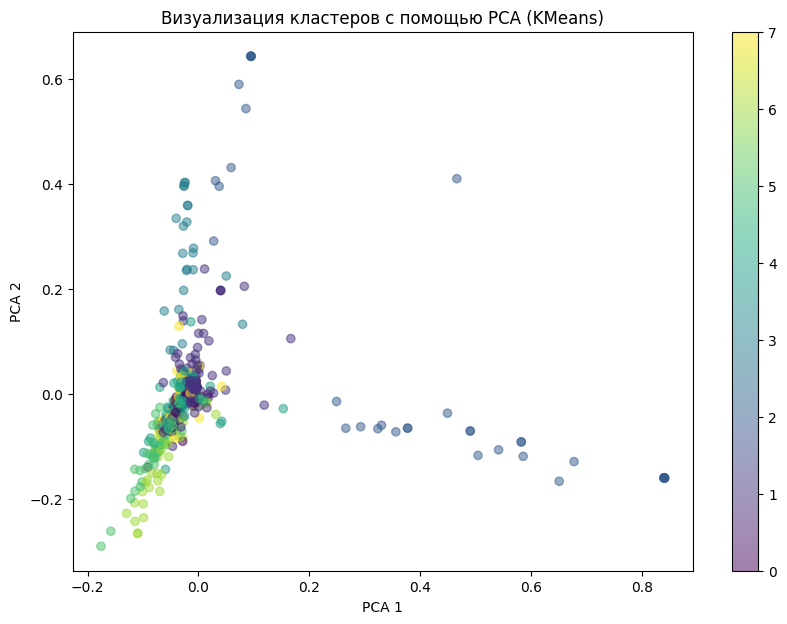

Кластер 0: целеполагание
Кластер 1: взаимоотношение
Кластер 2: обстоятельство
Кластер 3: переходить
Кластер 4: месторасположение
Кластер 5: удовлетворённость
Кластер 6: предложение
Кластер 7: атомспейс


In [24]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from keybert import KeyBERT

# Векторизация текста с использованием TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(data[0]).toarray()

# Кластеризация с использованием KMeans
n_clusters = 8  # Задайте количество кластеров
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data['cluster_kmeans'] = kmeans.fit_predict(X)

# Оценка качества кластеризации
silhouette_avg = silhouette_score(X, data['cluster_kmeans'])
print(f"Качество кластеризации (KMeans):", silhouette_avg)

# Визуализация результатов с использованием PCA
reduced_data = PCA(n_components=2).fit_transform(X)
plt.figure(figsize=(10, 7))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data['cluster_kmeans'], cmap='viridis', alpha=0.5)
plt.title('Визуализация кластеров с помощью PCA (KMeans)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()

# Инициализируем модель KeyBERT
keybert_model = KeyBERT()

# Получение репрезентативного слова для каждого кластера
def get_representative_word(cluster_label):
    cluster_data = data[data['cluster_kmeans'] == cluster_label]
    if cluster_data.empty:
        return "Нет данных"

    # Извлекаем тексты из кластера
    texts = cluster_data[0].tolist()
    # Получаем ключевое слово с использованием KeyBERT
    keywords = keybert_model.extract_keywords(' '.join(texts), top_n=1)

    # Возвращаем первое ключевое слово
    return keywords[0][0] if keywords else "Нет ключевых слов"

# Получение репрезентативного слова для каждого кластера
for i in range(n_clusters):
    representative_word =lemmatize_word( get_representative_word(i))

    print(f"Кластер {i}: {representative_word}")
